In [16]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from spender.data.desi import DESI

from imo.attribution import inverse_multiscale_occlusion
from imo.model import OutlierModel

In [2]:
weight_dir = "../weights"
model = OutlierModel.from_weights(
    f"{weight_dir}/spender.desi-edr.galaxyae-b9bc8d12.pt",
    f"{weight_dir}/galaxy-flow-state_dict.pt",
    device="cpu",
)

In [3]:
with open("../data/DESI_EDR_top200_outliers.pkl", "rb") as f:
    data = pickle.load(f)

spectra, weights = [
    torch.from_numpy(np.stack([data[i][k] for i in range(1, 201)]))
    for k in ["spectrum", "weight"]
]

selkeys = ["target_id", "z", "ra", "dec", "-logP"]
metadata = dict(
    zip(
        selkeys,
        (
            torch.from_numpy(np.stack([data[i][k] for i in range(1, 201)]))
            for k in selkeys
        ),
    )
)

baselines = torch.from_numpy(np.load("../data/baselines.npy"))

In [10]:
ix = 3

mso_attr, abl, imow = inverse_multiscale_occlusion(
    model,
    spectra[ix],
    baselines[:8],
    metadata["z"][ix],
    window_sizes=[32, 64, 128],
    offsets=[0, 0, 0],
    avg_over_baselines=False,
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
imo = (mso_attr.mean(axis=1) * (1 / imow)).sum(axis=0) / (1 / imow).sum(axis=0)

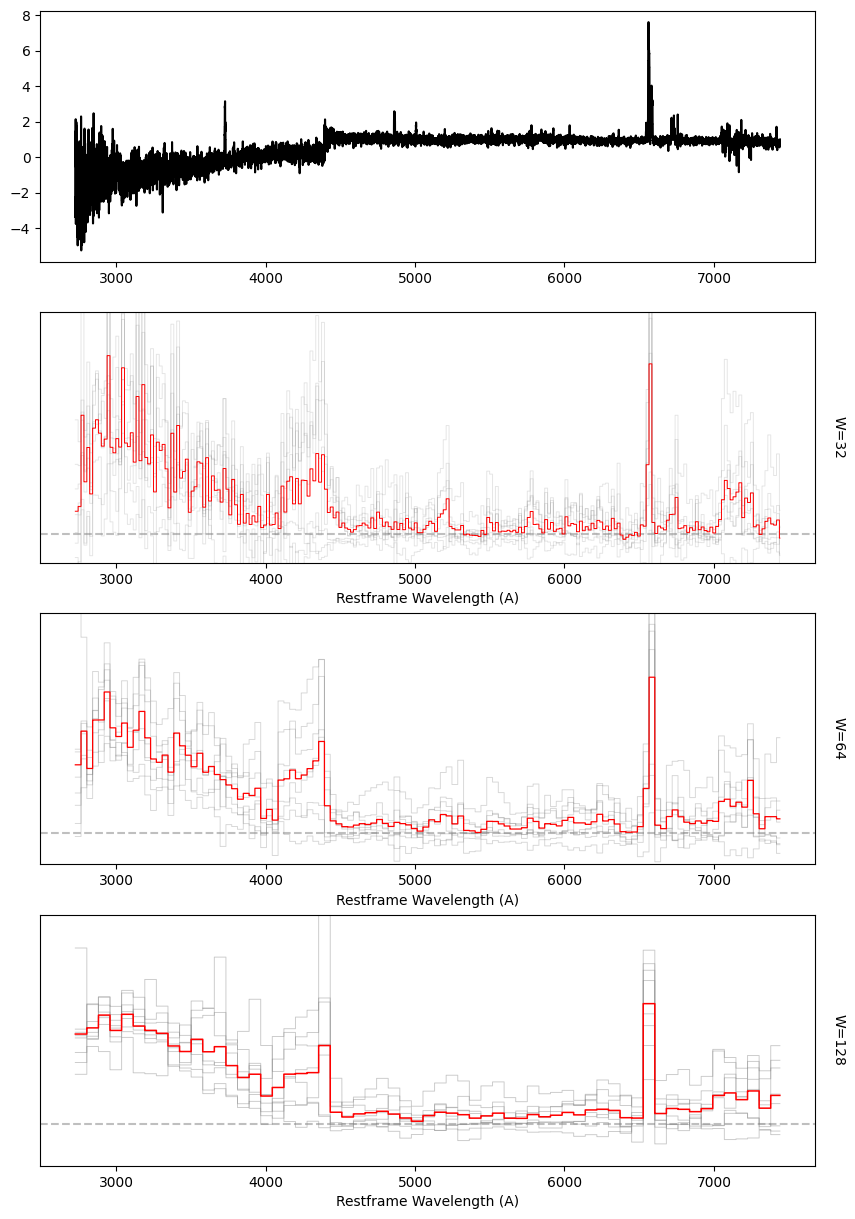

In [24]:
xwave = DESI._wave_obs / (1 + metadata["z"][ix].item())

fig, ax = plt.subplots(4, 1, figsize=(10, 15))

ax[0].step(xwave, spectra[ix], c="k")

for j in range(3):
    ax[j + 1].step(
        xwave,
        mso_attr[j].T,
        c="gray",
        alpha=0.2 + 0.1 * j,
        zorder=-5,
        lw=0.7,
        rasterized=True,
    )
    ax[j + 1].step(xwave, mso_attr[j].mean(axis=0), c="red", lw=0.7 + 0.2 * j)
    ax[j + 1].axhline(0, c="gray", alpha=0.5, ls="--", zorder=-5)
    ax[j + 1].set_ylabel(f"W={[32, 64, 128][j]}", rotation=270, labelpad=22)
    ax[j + 1].set_yticks([])
    ax[j + 1].yaxis.set_label_position("right")
    ax[j + 1].set_xlabel("Restframe Wavelength (A)")
    # ax_right[j].plot(DESI._wave_obs, (star_spec[2]) / star_spec[2].std() * np.einsum('bp,bd -> p', mso_attr[j], blw).std() * 1.2, c='#A3BE8C', zorder=5, lw=0.3)
    # ax_right[j].set_xlim(6500, 6650)
    ax[j + 1].set_ylim(
        *np.quantile(mso_attr[j].mean(axis=0), [0.005, 0.995]) + np.array([-0.05, 0.1])
    )